# Set up environment

In [117]:
# convert jupyter to python
# !jupyter-nbconvert --to script gan_mlp_lstm_fx.ipynb

In [118]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# control GPU memory usages
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [119]:
# check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [120]:
# check devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5314387658350436045
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18286503573773835240
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15942398944792179718
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4228513792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8991962296494914832
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
]


# Import modules

In [121]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams["font.size"] = 18
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Dropout, Input, Reshape, Bidirectional, Embedding
from keras.layers import LSTM, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD, Adamax, RMSprop
from keras_ordered_neurons import ONLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard

from tqdm import tqdm, tqdm_notebook

# Import data

For data acquisition and pre-processing, see data_process_fx.ipynb 

In [122]:
# !ls 

## Get train data

In [123]:
# get train dataset
df_train = pd.read_csv("USDJPY/usdjpy_train.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2010-2017.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2015-2017.csv")

if "Date" in df_train.columns:
    df_train.sort_values("Date", inplace=True)
else:
    df_train.sort_values("datetime", inplace=True)   
df_train.head()
# df_train.dtypes

,datetime,Open
0,2018-01-02 10:00:00,112.37
1,2018-01-03 10:00:00,112.33
2,2018-01-04 10:00:00,112.61
3,2018-01-05 10:00:00,113.19
4,2018-01-08 10:00:00,113.22


## Get test data

In [124]:
# get test dataset
df_test0 = pd.read_csv("USDJPY/usdjpy_test.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")

if "Date" in df_train.columns:
    df_test0.sort_values("Date", inplace=True)
else:
    df_test0.sort_values("datetime", inplace=True)
df_test0.head()

,datetime,Open
0,2019-01-01 10:00:00,109.59
1,2019-01-02 10:00:00,108.94
2,2019-01-03 10:00:00,107.63
3,2019-01-04 10:00:00,108.01
4,2019-01-07 10:00:00,108.19


## Convert price data to diff price data

In [125]:
# http://philipperemy.github.io/keras-stateful-lstm/

In [126]:
df_train["diff"] = np.where(df_train["Open"].diff()>=0, 1, -1) 
df_test0["diff"] = np.where(df_test0["Open"].diff()>=0, 1, -1) 
df_train.head()

,datetime,Open,diff
0,2018-01-02 10:00:00,112.37,-1
1,2018-01-03 10:00:00,112.33,-1
2,2018-01-04 10:00:00,112.61,1
3,2018-01-05 10:00:00,113.19,1
4,2018-01-08 10:00:00,113.22,1


# Set up parameter and process data shape

In [128]:
# set up parameters and features for training
batch_size = 60 #60
lstm_batch_size = 60 #60 #timestep
epochs = 100 #100
split_validate_test = 0.2
selected_features = ["Open"] # ["Open", "Vol"] # the first column should be the one would like to predict
# selected_features = ["diff"] # ["Open", "Vol"] # the first column should be the one would like to predict

In [130]:
# process train data
data_train = df_train[selected_features].values 
print ("data_train", data_train.shape)
benchmark_actual_train = df_train[selected_features].iloc[lstm_batch_size:].values
print ("benchmark_actual_train", benchmark_actual_train.shape)

# calculate number of features
num_features = data_train.shape[1]
print ("num_features", num_features)

# normalise data
scaler_train = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = scaler_train.fit_transform(data_train)
scaler_train_output = MinMaxScaler(feature_range = (0, 1))
data_train_scaled_output = scaler_train_output.fit_transform(data_train[:,0:1])

# convert data shape for lstm
def convert_data_shape_for_lstm(data_scaled, lstm_batch_size):
    features0 = []
    labels0 = []
    for i in range(lstm_batch_size, len(data_scaled)-1):
        features0.append(data_scaled[i-lstm_batch_size:i, 0:data_scaled.shape[1]])
#         labels0.append(data_scaled[i, 0])
        labels0.append(data_scaled[i:i+2,0])
        
    # reshape
    features0, labels0 = np.array(features0), np.array(labels0)
    print (features0.shape, labels0.shape)
    features0 = np.reshape(features0, (features0.shape[0], features0.shape[1], data_scaled.shape[1]))
    labels0 = np.reshape(labels0, (labels0.shape[0], labels0.shape[1], ))
#     labels0 = np.reshape(labels0, (labels0.shape[0],labels0.shape[1], data_scaled.shape[1]))
    print ("features", features0.shape)
    print ("labels", labels0.shape)
    return features0, labels0

train_features, train_labels = convert_data_shape_for_lstm(data_train_scaled, lstm_batch_size)

data_train (259, 1)
benchmark_actual_train (199, 1)
num_features 1
(198, 60, 1) (198, 2)
features (198, 60, 1)
labels (198, 2)


In [131]:
## process test data
data_total = pd.concat((df_train[selected_features], df_test0[selected_features]), axis=0)
print ("data_total", data_total.shape)
data_test = data_total[len(data_total) - len(df_test0) - lstm_batch_size + 1:].values
print ("data_test", data_test.shape)

# normalise data
scaler_test = MinMaxScaler(feature_range = (0, 1))
data_test_scaled = scaler_train.fit_transform(data_test)

# convert data shape for lstm
test_features0, test_labels0 = convert_data_shape_for_lstm(data_test_scaled, lstm_batch_size)

# seperate validate and test
validate_features = test_features0[0:int(len(test_features0)*split_validate_test)]
test_features = test_features0[int(len(test_features0)*split_validate_test):]
validate_labels = test_labels0[0:int(len(test_labels0)*split_validate_test)]
test_labels = test_labels0[int(len(test_labels0)*split_validate_test):]

benchmark_actual_test = data_test[int((len(test_features0))*split_validate_test)+lstm_batch_size:,]

print ("test_features", test_features.shape)
print ("validate_features", validate_features.shape)
print ("benchmark_actual_test", benchmark_actual_test.shape)

data_total (411, 1)
data_test (211, 1)
(150, 60, 1) (150, 2)
features (150, 60, 1)
labels (150, 2)
test_features (120, 60, 1)
validate_features (30, 60, 1)
benchmark_actual_test (121, 1)


In [132]:
def plot_timeseries(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax2 = ax1.twinx()
        ax2.plot(real_data, color='b', label="real", linewidth=3.0)
        ax2.ticklabel_format(useOffset=False)
        plt.ylim([105,119])
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.xlabel("Day")
        plt.ylabel("Price")        
        ax1.legend()
        ax1.set_title('USDJPY: Epoch={}'.format(epoch), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()
    
def plot_timeseries2(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    print (len(generated_timeseries.T[0]), len(real_data))
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax1.plot(real_data, color='b', label="real", linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        plt.xlabel("Day")
        plt.ylabel("Price (USDJPY)")        
        ax1.legend()
        ax1.set_title('{}_{}_{}'.format(training_type, discriminator_type, generator_type), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()    

In [133]:
def predict_model_and_plot(case, model_case, selected_feature, features, model, benchmark_actual):
    lstm_predict = model.predict(features)
    print (lstm_predict.shape, features.shape)
    if selected_feature == "Open":
        lstm_predict = scaler_train_output.inverse_transform(lstm_predict)
    plot_timeseries(epochs, case, "", model_case, lstm_predict, benchmark_actual)
    plot_timeseries2(epochs, case, "", model_case, lstm_predict, benchmark_actual)   
    return lstm_predict

In [134]:
def calculate_confusion_matrix(selected_feature, model_prediction):
    print ("selected_feature", selected_feature)
    if selected_feature == "Open":
        y_true = np.where(np.diff(benchmark_actual_test.T[0])>0, 1, -1) 
        y_pred = np.where(np.diff(model_prediction[:,0])>0, 1, -1) 
    elif selected_feature == "diff":
        y_true = np.where(benchmark_actual_test.T[0]>=0, 1, -1) 
        y_pred = np.where(model_prediction[:,0]>=0.5, 1, -1) 
    cm = confusion_matrix(y_true, y_pred)
    print (cm)
    return cm

# LSTM

In [135]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

In [136]:
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=500, return_sequences=True, 
                        input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    
    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 2))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])

    return lstm_model
lstm_model = create_lstm_model()
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 500)           1004000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 500)           2002000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 60, 500)           2002000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 500)              

In [137]:
print (train_features.shape, train_labels.shape)
lstm_history = lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size,
                              validation_data=(validate_features, validate_labels),
                              shuffle=False)
lstm_score, lstm_acc = lstm_model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=0)
print (lstm_score, lstm_acc)

(198, 60, 1) (198, 2)
Train on 198 samples, validate on 30 samples
Epoch 1/100
198/198 [==============================] - 6s 29ms/step - loss: 0.7549 - acc: 0.4899 - val_loss: 0.4571 - val_acc: 0.3667
Epoch 2/100
198/198 [==============================] - 2s 12ms/step - loss: 0.1780 - acc: 0.4899 - val_loss: 0.0540 - val_acc: 0.3667
Epoch 3/100
198/198 [==============================] - 2s 13ms/step - loss: 0.1399 - acc: 0.4596 - val_loss: 0.0236 - val_acc: 0.6333
Epoch 4/100
198/198 [==============================] - 2s 12ms/step - loss: 0.0393 - acc: 0.5101 - val_loss: 0.0261 - val_acc: 0.3667
Epoch 5/100
198/198 [==============================] - 2s 13ms/step - loss: 0.0642 - acc: 0.4444 - val_loss: 0.0306 - val_acc: 0.6333
Epoch 6/100
198/198 [==============================] - 3s 13ms/step - loss: 0.0968 - acc: 0.5303 - val_loss: 0.0157 - val_acc: 0.6333
Epoch 7/100
198/198 [==============================] - 2s 12ms/step - loss: 0.0428 - acc: 0.4899 - val_loss: 0.0165 - val_acc: 0.

198/198 [==============================] - 3s 15ms/step - loss: 0.0193 - acc: 0.4596 - val_loss: 0.0532 - val_acc: 0.4667
Epoch 62/100
198/198 [==============================] - 3s 16ms/step - loss: 0.0160 - acc: 0.4646 - val_loss: 0.0944 - val_acc: 0.5000
Epoch 63/100
198/198 [==============================] - 3s 16ms/step - loss: 0.0245 - acc: 0.5000 - val_loss: 0.0795 - val_acc: 0.6000
Epoch 64/100
198/198 [==============================] - 3s 16ms/step - loss: 0.0171 - acc: 0.5354 - val_loss: 0.0884 - val_acc: 0.6333
Epoch 65/100
198/198 [==============================] - 3s 15ms/step - loss: 0.0156 - acc: 0.5354 - val_loss: 0.0803 - val_acc: 0.5667
Epoch 66/100
198/198 [==============================] - 3s 15ms/step - loss: 0.0145 - acc: 0.5404 - val_loss: 0.0642 - val_acc: 0.6333
Epoch 67/100
198/198 [==============================] - 3s 16ms/step - loss: 0.0169 - acc: 0.5556 - val_loss: 0.0963 - val_acc: 0.6333
Epoch 68/100
198/198 [==============================] - 3s 16ms/step

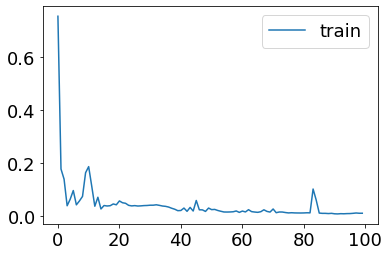

In [138]:
# plot history
plt.plot(lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

In [155]:
lstm_predict = lstm_model.predict(test_features)

In [156]:
# train_features

In [157]:
# lstm_predict

In [166]:
lstm_predict#[:,1:2]

array([[110.40667 , 110.30339 ],
       [110.52669 , 110.45814 ],
       [110.84916 , 110.813515],
       [110.98812 , 110.97166 ],
       [110.898926, 110.8837  ],
       [110.73167 , 110.71729 ],
       [110.6208  , 110.614296],
       [110.61068 , 110.61904 ],
       [110.7243  , 110.7457  ],
       [110.86278 , 110.88842 ],
       [110.99022 , 111.006294],
       [110.958855, 110.96604 ],
       [110.897766, 110.89697 ],
       [111.17492 , 111.15757 ],
       [111.69156 , 111.64945 ],
       [112.13909 , 112.05747 ],
       [112.24268 , 112.13828 ],
       [111.99702 , 111.912254],
       [111.439384, 111.4118  ],
       [110.81743 , 110.84106 ],
       [110.401375, 110.44871 ],
       [110.36974 , 110.44113 ],
       [110.857185, 110.96361 ],
       [111.60916 , 111.70134 ],
       [112.115585, 112.122856],
       [112.119545, 112.06395 ],
       [111.851654, 111.79073 ],
       [111.29121 , 111.272514],
       [110.66872 , 110.689964],
       [110.11207 , 110.15697 ],
       [10

120 199


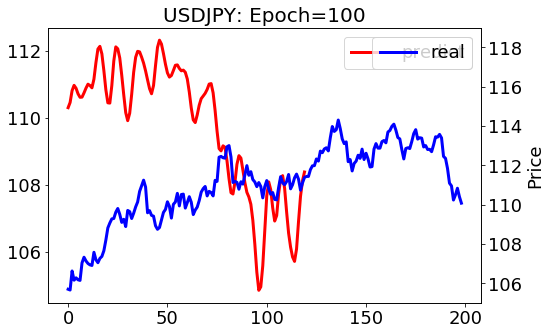

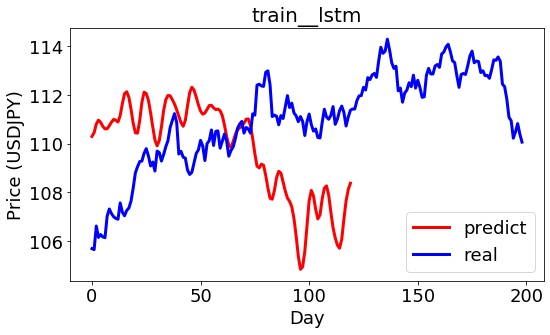

In [159]:
lstm_predict = scaler_train_output.inverse_transform(lstm_predict)
plot_timeseries(epochs, "train", "", "lstm", lstm_predict[:,1:2], benchmark_actual_train)
plot_timeseries2(epochs, "train", "", "lstm", lstm_predict[:,1:2], benchmark_actual_train)   

In [163]:
lstm_predict.shape, benchmark_actual_test[:-1].shape

((120, 2), (120, 1))

In [164]:
y_true = np.where(np.diff(benchmark_actual_test[:-1].T[0])>0, 1, -1) 
y_pred = np.where(np.diff(lstm_predict[:,0:1][:,0])>0, 1, -1) 
confusion_matrix(y_true, y_pred)

array([[33, 31],
       [32, 23]])

In [165]:
y_true = np.where(np.diff(benchmark_actual_test[:-1].T[0])>0, 1, -1) 
y_pred = np.where(np.diff(lstm_predict[:,1:2][:,0])>0, 1, -1) 
confusion_matrix(y_true, y_pred)

array([[34, 30],
       [31, 24]])

(198, 2) (198, 60, 1)


ValueError: num must be 1 <= num <= 1, not 2

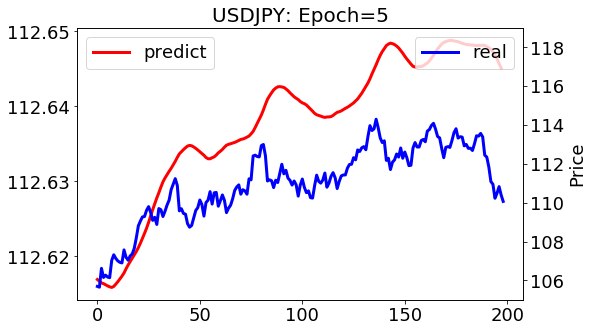

In [112]:
train_lstm_prediction = predict_model_and_plot("train", "lstm", selected_features[0], train_features, lstm_model, benchmark_actual_train)

## prediction

(121, 1) (121, 60, 1)
121 121


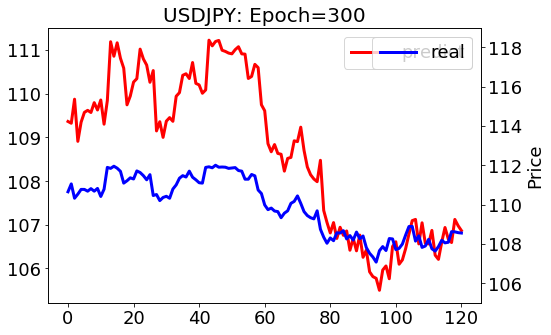

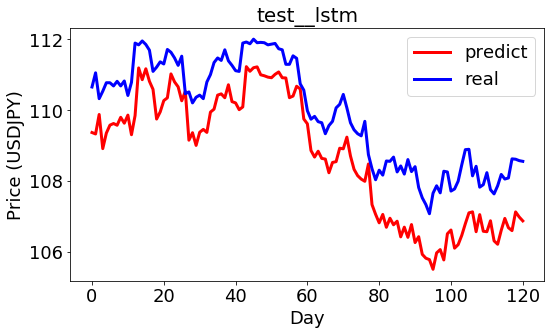

In [22]:
lstm_predictions = predict_model_and_plot("test", "lstm", selected_features[0], test_features, lstm_model, benchmark_actual_test)

In [23]:
calculate_confusion_matrix(selected_features[0], lstm_predictions)

selected_feature Open
[[31 34]
 [33 22]]


array([[31, 34],
       [33, 22]])

# Ordered-neurons LSTM

In [36]:
# https://arxiv.org/abs/1810.09536
# https://github.com/CyberZHG/keras-ordered-neurons/blob/master/README.md

In [37]:
def create_on_lstm_model():
    on_lstm_model = Sequential()
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True, 
                                        input_shape=(train_features.shape[1], train_features.shape[2])))
    on_lstm_model.add(Dropout(0.01))
    
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(Dense(units = 1))

    on_lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])
    
    return on_lstm_model
on_lstm_model = create_on_lstm_model()
on_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
onlstm_9 (ONLSTM)            (None, 60, 500)           1104400   
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
onlstm_10 (ONLSTM)           (None, 60, 500)           2202200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
onlstm_11 (ONLSTM)           (None, 60, 500)           2202200   
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 500)           0         
_________________________________________________________________
onlstm_12 (ONLSTM)           (None, 500)              

In [ ]:
# on_lstm_history = on_lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size)
on_lstm_history = on_lstm_model.fit(train_features, train_labels, 
                                    epochs = epochs, batch_size = batch_size,
                                    validation_data=(validate_features, validate_labels),
                                    shuffle=False)
on_lstm_score, on_lstm_acc = on_lstm_model.evaluate(test_features, test_labels, 
                                                    batch_size=batch_size, verbose=0)
print (on_lstm_score, on_lstm_acc)

Train on 199 samples, validate on 30 samples
Epoch 1/300
 60/199 [========>.....................] - ETA: 15s - loss: 0.1957 - acc: 0.0000e+00

In [ ]:
# plot history
plt.plot(on_lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

In [ ]:
train_on_lstm_predict = predict_model_and_plot("train", "onlstm", selected_features[0], train_features, on_lstm_model, benchmark_actual_train)
# train_on_lstm_predict = on_lstm_model.predict(train_features)
# print (train_on_lstm_predict.shape, train_features.shape)
# train_on_lstm_predict = scaler_train_output.inverse_transform(train_on_lstm_predict)
# plot_timeseries(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)
# plot_timeseries2(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)

In [ ]:
on_lstm_predictions = predict_model_and_plot("test", "onlstm", selected_features[0], test_features, on_lstm_model, benchmark_actual_test)
# on_lstm_predictions = on_lstm_model.predict(test_features)
# plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, 
#                  data_test_scaled[int(lstm_batch_size+len(test_features0)*split_validate_test):])
# on_lstm_predictions = scaler_train_output.inverse_transform(on_lstm_predictions)
# plot_timeseries(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)
# plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)

In [ ]:
calculate_confusion_matrix(selected_features[0], on_lstm_predictions)

# GAN

In [31]:
# https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
# https://qiita.com/taku-buntu/items/0093a68bfae0b0ff879d
# https://qiita.com/yoyoyo_/items/56c6fcbd5a853460f506

## Generator and Discriminator

In [32]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=1))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(units=1, activation='sigmoid'))    
    discriminator.compile(loss='binary_crossentropy', optimizer='RMSprop')
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [33]:
def create_gan(discriminator, generator, generator_type="lstm"):
    discriminator.trainable=False

    if generator_type=="mlp":
        gan_input = Input(shape=(num_features,))
    else:
        gan_input = Input(shape=(lstm_batch_size, num_features))
    print (gan_input.shape)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
                          
    return gan
gan = create_gan(d,on_lstm_model)
gan.summary()

(?, 60, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 7711501   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 165377    
Total params: 7,876,878
Trainable params: 7,711,501
Non-trainable params: 165,377
_________________________________________________________________


# Training

In [34]:
def training(epochs=1, batch_size=60, discriminator_type="gan", generator_type="lstm"):

    #Loading the data
    batch_count = int(train_features.shape[0] / batch_size)
    print ("batch_count", batch_count)
    print ("batch_size", batch_size)
    print ("lstm_batch_size", lstm_batch_size)
    
    # Creating GAN generator
    if generator_type == "lstm":
        generator = create_lstm_model()
    elif generator_type == "on_lstm":
        generator = create_on_lstm_model()
    elif generator_type == "mlp":
        generator = create_generator()
       
    # Creating GAN discriminator
    if discriminator_type == "gan":
        discriminator = create_discriminator()
    elif discriminator_type == "wgan":
        discriminator = create_wgan_discriminator()

    # Creating GAN 
    gan = create_gan(discriminator, generator, generator_type)

    # Set up label for valid and fake conditions
    valid = np.ones((batch_size, 1)) * 1.0 # prevent overconfidence by penalising the discriminator (1=>0.9)
    # valid = np.ones((batch_size, 1)) * 0.9 # prevent overconfidence by penalising the discriminator (1=>0.9)
    fake = np.zeros((batch_size, 1))    
    actual_data_train_all = data_train_scaled[lstm_batch_size:,0]
    losses = []
    
    for epoch in range(1,epochs+1 ):
        for i in range(batch_count):
            
            # Generate fake time-series from lstm model input
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                generated_timeseries = generator.predict(noise)               
            else:
                train_timeseries_batch = train_features[batch_size*i:batch_size*(i+1),:,:]
                generated_timeseries = generator.predict(train_timeseries_batch) 

            # Train the discriminator (real classified as ones and generated as zeros)
            actual_data_train = actual_data_train_all[batch_size*i:batch_size*(i+1)]
            discriminator.trainable=True
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([actual_data_train, generated_timeseries[:,0]])
            y = np.concatenate([valid, fake])
            d_loss = discriminator.train_on_batch(X, y)
            discriminator.trainable=False
            
            # Train Generator: combined model  (stacked generator and discriminator)
            # Train the generator (wants discriminator to mistake images as real)  
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                g_loss = gan.train_on_batch(noise, valid)
            else:
                g_loss = gan.train_on_batch(train_timeseries_batch, valid)

            # Print out losses
            print ("Epoch: %d, Batch_count: %d, [D loss: %f] [G loss: %f]" % (epoch, batch_count, d_loss, g_loss))
            losses.append([epoch, d_loss, g_loss])
        
        if epoch == 1 or epoch % 100 == 0:
            if generator_type == "mlp":
                noise_train = np.random.uniform(-1, 1, (train_features.shape[0], num_features))
                generated_timeseries_predict_train = generator.predict(noise_train)
                noise_test = np.random.uniform(-1, 1, (test_features.shape[0], num_features))
                generated_timeseries_predict_test = generator.predict(noise_test)
            else:
                generated_timeseries_predict_train = generator.predict(train_features)
                generated_timeseries_predict_test = generator.predict(test_features)
            
            # Inverse transform using train fit_transform model for both train and test sets
            train_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_train)
            test_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_test)
            
            # Plot train and test
            plot_timeseries(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            plot_timeseries2(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries2(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            
            # Save model
            generator.save('train_model/generator_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
            gan.save('train_model/gan_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
    return test_predictions, losses, generator

# GAN + ON-LSTM

batch_count 3
batch_size 60
lstm_batch_size 60
(?, 60, 1)
Epoch: 1, Batch_count: 3, [D loss: 0.698749] [G loss: 0.667282]
Epoch: 1, Batch_count: 3, [D loss: 0.637453] [G loss: 0.681938]
Epoch: 1, Batch_count: 3, [D loss: 0.537760] [G loss: 0.704895]
199 199
121 121
Epoch: 2, Batch_count: 3, [D loss: 0.570631] [G loss: 0.722264]
Epoch: 2, Batch_count: 3, [D loss: 0.507296] [G loss: 0.732509]
Epoch: 2, Batch_count: 3, [D loss: 0.547346] [G loss: 0.663063]
Epoch: 3, Batch_count: 3, [D loss: 0.803079] [G loss: 0.678587]
Epoch: 3, Batch_count: 3, [D loss: 1.565521] [G loss: 1.367060]
Epoch: 3, Batch_count: 3, [D loss: 0.664873] [G loss: 1.517705]
Epoch: 4, Batch_count: 3, [D loss: 0.674662] [G loss: 1.034162]
Epoch: 4, Batch_count: 3, [D loss: 0.733240] [G loss: 0.887737]
Epoch: 4, Batch_count: 3, [D loss: 0.761965] [G loss: 0.806537]
Epoch: 5, Batch_count: 3, [D loss: 0.709223] [G loss: 0.778071]
Epoch: 5, Batch_count: 3, [D loss: 0.715179] [G loss: 0.770459]
Epoch: 5, Batch_count: 3, [D l

Epoch: 43, Batch_count: 3, [D loss: 0.791068] [G loss: 0.670096]
Epoch: 43, Batch_count: 3, [D loss: 0.679440] [G loss: 0.720198]
Epoch: 43, Batch_count: 3, [D loss: 0.697652] [G loss: 0.764529]
Epoch: 44, Batch_count: 3, [D loss: 0.720924] [G loss: 0.789799]
Epoch: 44, Batch_count: 3, [D loss: 0.621229] [G loss: 0.811127]
Epoch: 44, Batch_count: 3, [D loss: 0.547640] [G loss: 0.848879]
Epoch: 45, Batch_count: 3, [D loss: 0.696702] [G loss: 0.831890]
Epoch: 45, Batch_count: 3, [D loss: 0.573075] [G loss: 0.843516]
Epoch: 45, Batch_count: 3, [D loss: 0.487565] [G loss: 0.900736]
Epoch: 46, Batch_count: 3, [D loss: 0.687529] [G loss: 0.837620]
Epoch: 46, Batch_count: 3, [D loss: 0.532327] [G loss: 0.865321]
Epoch: 46, Batch_count: 3, [D loss: 0.440054] [G loss: 0.944874]
Epoch: 47, Batch_count: 3, [D loss: 0.692438] [G loss: 0.840884]
Epoch: 47, Batch_count: 3, [D loss: 0.507462] [G loss: 0.885377]
Epoch: 47, Batch_count: 3, [D loss: 0.409956] [G loss: 0.985433]
Epoch: 48, Batch_count: 3

Epoch: 85, Batch_count: 3, [D loss: 0.626160] [G loss: 0.757205]
Epoch: 85, Batch_count: 3, [D loss: 0.537766] [G loss: 0.884793]
Epoch: 86, Batch_count: 3, [D loss: 0.713877] [G loss: 0.763836]
Epoch: 86, Batch_count: 3, [D loss: 0.604562] [G loss: 0.749162]
Epoch: 86, Batch_count: 3, [D loss: 0.496964] [G loss: 0.916876]
Epoch: 87, Batch_count: 3, [D loss: 0.727614] [G loss: 0.786483]
Epoch: 87, Batch_count: 3, [D loss: 0.589644] [G loss: 0.728937]
Epoch: 87, Batch_count: 3, [D loss: 0.457434] [G loss: 0.930039]
Epoch: 88, Batch_count: 3, [D loss: 0.744047] [G loss: 0.800994]
Epoch: 88, Batch_count: 3, [D loss: 0.580582] [G loss: 0.709866]
Epoch: 88, Batch_count: 3, [D loss: 0.431800] [G loss: 0.958440]
Epoch: 89, Batch_count: 3, [D loss: 0.769136] [G loss: 0.845389]
Epoch: 89, Batch_count: 3, [D loss: 0.605289] [G loss: 0.623337]
Epoch: 89, Batch_count: 3, [D loss: 0.456157] [G loss: 0.926378]
Epoch: 90, Batch_count: 3, [D loss: 0.784934] [G loss: 0.836409]
Epoch: 90, Batch_count: 3

Epoch: 127, Batch_count: 3, [D loss: 0.735275] [G loss: 0.736182]
Epoch: 127, Batch_count: 3, [D loss: 0.698321] [G loss: 0.727507]
Epoch: 127, Batch_count: 3, [D loss: 0.667365] [G loss: 0.729574]
Epoch: 128, Batch_count: 3, [D loss: 0.729529] [G loss: 0.706359]
Epoch: 128, Batch_count: 3, [D loss: 0.697643] [G loss: 0.701346]
Epoch: 128, Batch_count: 3, [D loss: 0.668570] [G loss: 0.703015]
Epoch: 129, Batch_count: 3, [D loss: 0.726228] [G loss: 0.684396]
Epoch: 129, Batch_count: 3, [D loss: 0.697885] [G loss: 0.682797]
Epoch: 129, Batch_count: 3, [D loss: 0.669737] [G loss: 0.685296]
Epoch: 130, Batch_count: 3, [D loss: 0.723288] [G loss: 0.669839]
Epoch: 130, Batch_count: 3, [D loss: 0.698077] [G loss: 0.668521]
Epoch: 130, Batch_count: 3, [D loss: 0.669721] [G loss: 0.662240]
Epoch: 131, Batch_count: 3, [D loss: 0.724413] [G loss: 0.656526]
Epoch: 131, Batch_count: 3, [D loss: 0.699610] [G loss: 0.659129]
Epoch: 131, Batch_count: 3, [D loss: 0.672572] [G loss: 0.664334]
Epoch: 132

KeyboardInterrupt: 

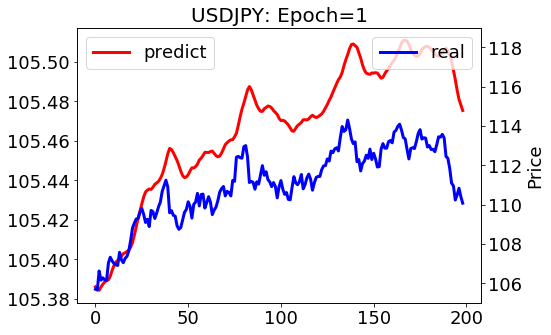

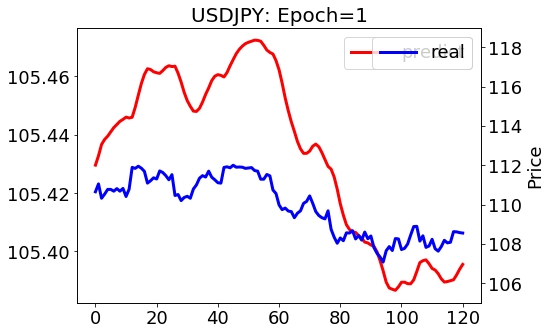

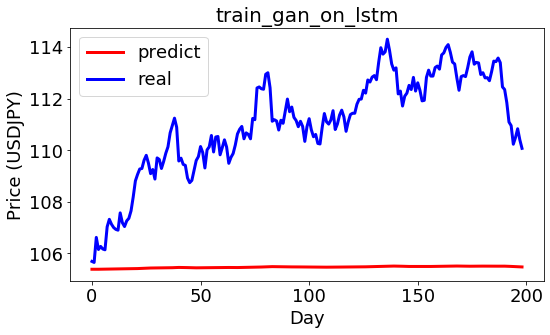

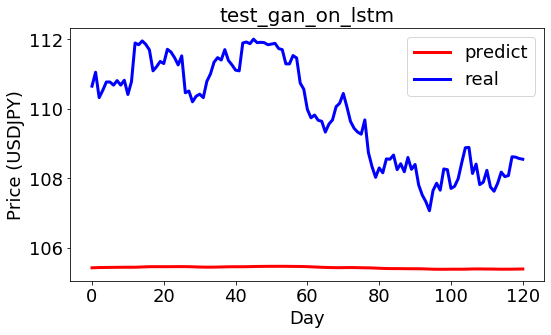

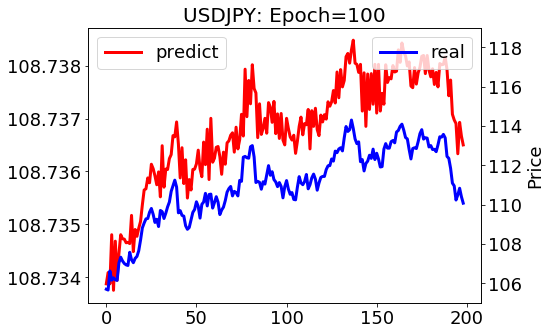

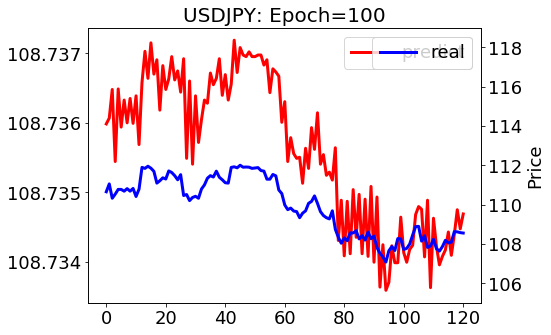

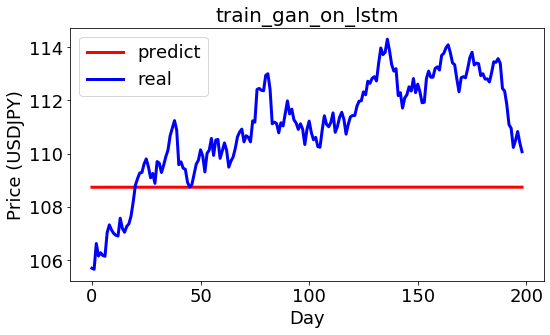

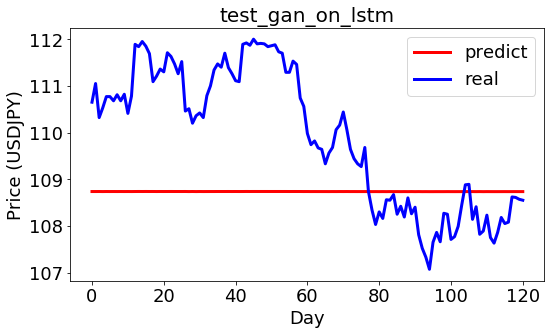

In [35]:
gan_onlstm_predictions, gan_onlstm_losses, gan_onlstm_generator = training(epochs, batch_size, "gan", "on_lstm")

In [ ]:
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[1], label='d_loss')
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[2], label='g_loss')
plt.legend()

In [ ]:
calculate_confusion_matrix(selected_features[0], gan_onlstm_predictions)

# Compare performance

In [ ]:
def accuracy_evaluation(method, true, prediction):
    # mean absolute error
    mae = mean_absolute_error(true, prediction)
    # mean absolute percentage error
    mape = np.mean(np.abs((true - prediction) / true)) * 100
    # root mean squared error
    rmse = np.sqrt(mean_squared_error(true, prediction))
    # mean squared error
    mse = mean_squared_error(true, prediction)
    # correlation coefficient
    corr = np.corrcoef(np.concatenate((np.transpose(true), np.transpose(prediction)), axis=0))[0,1]
    print ("{}:\tmae:{:.5}\tmape:{:.5}\trmse:{:.5}\tmse:{:.5}\tcorr:{:.3}".format(method, mae, mape, rmse, mse, corr))
    return

In [ ]:
accuracy_evaluation("lstm\t", benchmark_actual_test, lstm_predictions)
accuracy_evaluation("onlstm\t", benchmark_actual_test, on_lstm_predictions)
accuracy_evaluation("gan_onlstm", benchmark_actual_test, gan_onlstm_predictions)

# Trading

In [ ]:
abs(np.diff(benchmark_actual_test.T[0])).mean()

In [ ]:
def trading_profit(actual, predict, trading_type):
    tc = 0.0015
    profit = 0
    profit2 = 0
    trade_vol = 100000
    transaction_count = 0
    answer = 0
    answer2 = 0
    ans_increase = 0
    ans_decrease = 0
    increase = 0
    decrease = 0
    for i in range(len(actual)-1):
        # print (actual[i], actual[i+1], predict[i], predict[i+1]) 
        if predict[i] <= predict[i+1]:
            trade_diff = actual[i+1] - actual[i]
            transaction_count += 1
        else:
            if trading_type == 'buy_only':
                trade_diff = 0
            else:
                trade_diff = actual[i] - actual[i+1]
                transaction_count += 1
        answer += abs(actual[i+1] - actual[i]) * trade_vol
        answer2 += (abs(actual[i+1] - actual[i])-tc) * trade_vol
        if actual[i+1] - actual[i] >=0:
            ans_increase += 1
            if  predict[i+1] >= predict[i]:
                increase += 1
        else:
            ans_decrease += 1
            if  predict[i+1] < predict[i]:
                decrease += 1
        profit += trade_diff * trade_vol
        profit2 += (trade_diff-tc) * trade_vol
        #print (i, abs(actual[i+1] - actual[i]))
    print ("\n[ANSWER] max profit:{:}, {:}".format(answer, answer2))
    print ("trading_type: {}\t transaction_count: {}\t total_profit: {}\t profit/max_profit: {:.4}".format(
        trading_type, transaction_count, profit, float(profit/answer*100)))
    print ("trading_type2: {}\t transaction_count: {}\t total_profit2: {}\t profit2/max_profit2: {:.4}".format(
        trading_type, transaction_count, profit2, float(profit2/answer2*100)))
    print ("ans_increase:{}\tans_decrease:{}\tincrease:{}\tdecrease:{}\t{:}".format(
        ans_increase, ans_decrease, increase, decrease, (increase+decrease)/(ans_increase+ans_decrease)*100,))
    return profit

In [167]:
lstm_predict1 = trading_profit(benchmark_actual_test, lstm_predictions[:,0], 'buy_only')
lstm_predict2 = trading_profit(benchmark_actual_test, lstm_predictions[:,0], 'buy_sell')

NameError: name 'trading_profit' is not defined

In [ ]:
on_lstm_predict1 = trading_profit(benchmark_actual_test, on_lstm_predictions[:,0], 'buy_only')
on_lstm_predict2 = trading_profit(benchmark_actual_test, on_lstm_predictions[:,0], 'buy_sell')

In [ ]:
gan_onlstm_predictions1 = trading_profit(benchmark_actual_test, gan_onlstm_predictions, 'buy_only')
gan_onlstm_predictions2 = trading_profit(benchmark_actual_test, gan_onlstm_predictions, 'buy_sell')